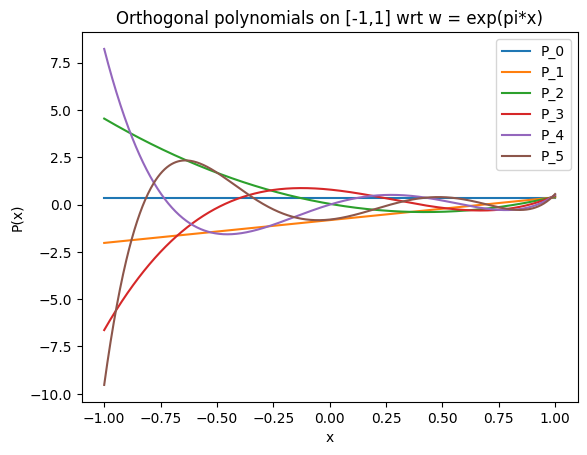

Orthogonality error: 8.595980570780976e-16


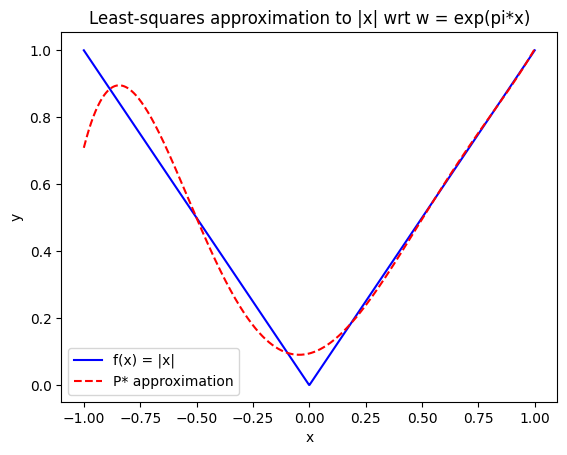

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad


def orth_poly(w_func, N, domain=[-1, 1]):
    """
    Generate a list of orthogonal polynomials with respect to a given weight function.
    Parameters:
    w_func (function): Weight function w(x) used in the inner product.
    N (int): The highest degree of the orthogonal polynomials to generate.
    domain (list, optional): The integration domain for the inner product, default is [-1, 1].
    Returns:
    list: A list of functions representing the orthogonal polynomials.
    Example:
    >>> w_func = lambda x: 1
    >>> polys = orth_poly(w_func, 3)
    >>> for p in polys:
    >>>     print(p(0.5))
    """
    def inner_product(f, g):
        integrand = lambda x: w_func(x) * f(x) * g(x)
        result, _ = quad(integrand, domain[0], domain[1])
        return result
    
    def normalize(f):
        norm = np.sqrt(inner_product(f, f))
        return lambda x: f(x) / norm

    # Define the orthogonal polynomials
    def constant_poly(x):
        return np.ones_like(x)
    
    polynomials = [normalize(constant_poly)]
    
    for k in range(1, N + 1):
        def x_poly(x, k=k):
            return x * polynomials[k-1](x)
        
        for j in range(k):
            proj_coeff = inner_product(x_poly, polynomials[j]) / inner_product(polynomials[j], polynomials[j])
            def new_x_poly(x, poly=x_poly, pj=polynomials[j], c=proj_coeff):
                return poly(x) - c * pj(x)
            x_poly = new_x_poly
        
        polynomials.append(normalize(x_poly))

    return polynomials

def plot_polynomials(polynomials, w_func, N, domain=[-1, 1]):
    x = np.linspace(domain[0], domain[1], 1000)
    w = w_func(x)
    
    for i in range(N + 1):
        plt.plot(x, polynomials[i](x), label=f'P_{i}')
    
    plt.title('Orthogonal polynomials on [-1,1] wrt w = exp(pi*x)')
    plt.xlabel('x')
    plt.ylabel('P(x)')
    plt.legend()
    plt.show()

def test_orthogonality(polynomials, w_func, N, domain=[-1, 1]):
    def inner_product(f, g):
        integrand = lambda x: w_func(x) * f(x) * g(x)
        result, _ = quad(integrand, domain[0], domain[1])
        return result
    
    I = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(N + 1):
            I[i, j] = inner_product(polynomials[i], polynomials[j])
    
    err = np.linalg.norm(I - np.eye(N + 1))
    print(f"Orthogonality error: {err}")

def least_squares_approximation(polynomials, w_func, f, N, domain=[-1, 1]):
    def inner_product(f, g):
        integrand = lambda x: w_func(x) * f(x) * g(x)
        result, _ = quad(integrand, domain[0], domain[1])
        return result
    
    alpha = np.zeros(N + 1)
    for k in range(N + 1):
        alpha[k] = inner_product(f, polynomials[k])
    
    def P_star(x):
        return sum(alpha[k] * polynomials[k](x) for k in range(N + 1))

    x = np.linspace(domain[0], domain[1], 1000)
    plt.plot(x, f(x), 'b', label='f(x) = |x|')
    plt.plot(x, P_star(x), '--r', label='P* approximation')
    plt.title('Least-squares approximation to |x| wrt w = exp(pi*x)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# Define the weight function
w_func = lambda x: np.exp(np.pi * x)
N = 5

# Generate orthogonal polynomials
polynomials = orth_poly(w_func, N)

# Plot the polynomials
plot_polynomials(polynomials, w_func, N)

# Test orthogonality
test_orthogonality(polynomials, w_func, N)

# Least-squares approximation
f = lambda x: np.abs(x)
least_squares_approximation(polynomials, w_func, f, N)


In [4]:
polynomials

[<function __main__.orth_poly.<locals>.normalize.<locals>.<lambda>(x)>,
 <function __main__.orth_poly.<locals>.normalize.<locals>.<lambda>(x)>,
 <function __main__.orth_poly.<locals>.normalize.<locals>.<lambda>(x)>,
 <function __main__.orth_poly.<locals>.normalize.<locals>.<lambda>(x)>,
 <function __main__.orth_poly.<locals>.normalize.<locals>.<lambda>(x)>,
 <function __main__.orth_poly.<locals>.normalize.<locals>.<lambda>(x)>]

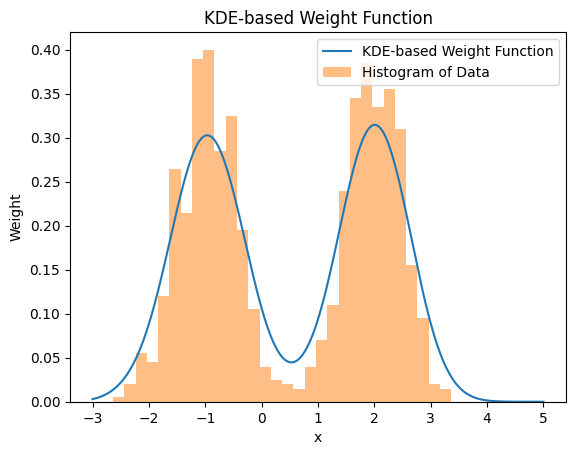

In [5]:
from scipy.stats import gaussian_kde

# Function to create a KDE-based weight function compatible with orth_poly
def kde_weight_function(data, domain, bw_method='scott'):
    # Create the KDE
    kde = gaussian_kde(data, bw_method=bw_method)

    # Normalize the KDE to ensure it's a valid weight function over the domain
    normalization_factor = np.trapz(kde(domain), domain)
    
    def w_func(x):
        return kde(x) / normalization_factor
    
    return w_func

# Generate toy data for testing (e.g., bimodal distribution)
toy_data = np.concatenate([np.random.normal(-1, 0.5, size=500), np.random.normal(2, 0.5, size=500)])

# Define the domain for the weight function
x_domain = np.linspace(-3, 5, 1000)

# Generate the weight function using KDE
w = kde_weight_function(toy_data, x_domain)

# Plot the weight function
plt.plot(x_domain, w(x_domain), label='KDE-based Weight Function')
plt.hist(toy_data, bins=30, density=True, alpha=0.5, label='Histogram of Data')
plt.title('KDE-based Weight Function')
plt.xlabel('x')
plt.ylabel('Weight')
plt.legend()
plt.show()


In [8]:
import sympy as sp
def print_polynomial_equations(polynomials):
    x = sp.symbols('x')
    for i, poly in enumerate(polynomials):
        poly_expr = sp.simplify(sp.lambdify(x, poly(x))(x))
        print(f"P_{i}(x) = {poly_expr}")

# Generate toy weight function for testing
toy_weight_func = kde_weight_function(toy_data, x_domain)

# Generate orthogonal polynomials
polys = orth_poly(toy_weight_func, 5)

# Print the polynomial equations
print_polynomial_equations(polys)

P_0(x) = 1.85850511902755
P_1(x) = 3.55683779370012*x + 1.23500355351913
P_2(x) = 6.40963352874602*x**2 + 1.23844605081267*x - 2.09271980989367
P_3(x) = 13.2362260523776*x**3 + 2.81737527354474*x**2 - 8.34727660305239*x - 1.50010263724235
P_4(x) = 26.1442746766567*x**4 + 6.03905225677804*x**3 - 22.5174309059439*x**2 - 4.44659667019974*x + 1.94793273258764
P_5(x) = 51.8726247524482*x**5 + 11.4595245503533*x**4 - 58.0930958584217*x**3 - 11.2024803256177*x**2 + 12.3385686179767*x + 1.46792018027363


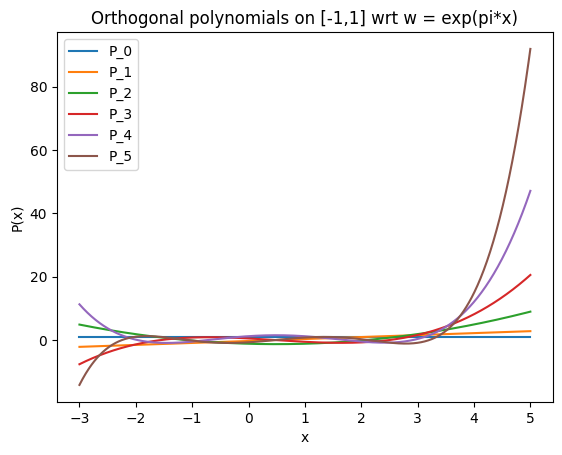

Orthogonality error: 9.941645604904776e-16


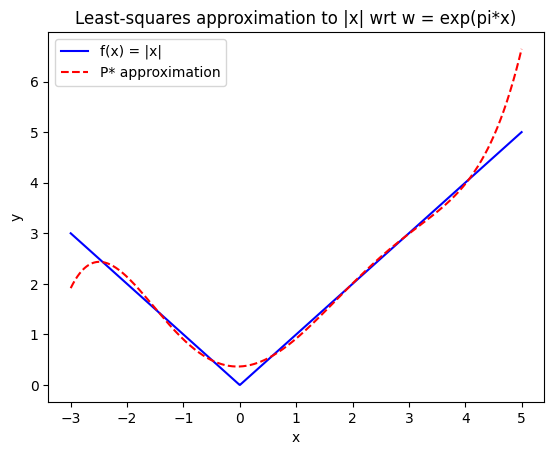

In [6]:
# Generate orthogonal polynomials based on the KDE-based weight function
polynomials_kde = orth_poly(w, N, domain=[-3, 5])

# Plot the polynomials
plot_polynomials(polynomials_kde, w, N, domain=[-3, 5])

# Test orthogonality
test_orthogonality(polynomials_kde, w, N, domain=[-3, 5])

# Least-squares approximation
least_squares_approximation(polynomials_kde, w, f, N, domain=[-3, 5])

In [9]:
np.sqrt(np.square(15.4) + np.square(11))

18.925115587493778